# $n$-step return actor-critic
이전 장에서는 online/batch actor-critic이 네트워크를 업데이트할 때 타겟값으로 $r_t + \gamma V_{\phi}(s_{t+1}) - V_{\phi}(s_{t})$를 사용한다는 것을 알아보았다. 이는 상태가치함수의 다음과 같은 성질을 이용한 것이었다. 확률변수는 대문자로 표기해주었다.

$$V^{\pi}(s_t)= \mathbb{E}_{A_t \sim \pi(\cdot|s_t), S_{t+1} \sim p(\cdot|s_t,A_t)} \left[ r(s_t, A_t) + \gamma  V^{\pi}(S_{t+1}) \mid S_t = s_t \right] \; \text{ for all } \; s_t \in \mathcal{S}.$$

<br>

그리고 위 식의 기댓값을 직접 구하는 대신 확률변수에 실제 데이터를 대입하여 상태가치함수의 추정치로 사용했다.

$$V^{\pi}(s_t) \approx  r_t + \gamma V^{\pi}(s_{t+1}).$$

<br>

위 상태가치함수의 성질에서 재귀적 성질을 다시 한 번 이용하여 $V^{\pi}(s_{t+1})$ 대신 $r_{t+1} + \gamma V^{\pi}(s_{t+2})$을 사용해줄 수 있다.

$$V^{\pi}(s_t)= \mathbb{E}_{\pi_{\theta}} \left[ r(s_t, A_t) +  \gamma r(S_{t+1}, A_{t+1}) + \gamma^2  V^{\pi}(S_{t+2}) \mid S_t = s_t\right] \; \text{ for all } \; s_t \in \mathcal{S}.$$

<br>

마찬가지로 확률변수에 실제 데이터를 넣어서 상태가치함수에 대한 또 다른 추정치를 만들 수 있다.

$$V^{\pi}(s_t) \approx  r_t + \gamma r_{t+1} + \gamma^2 V^{\pi}(s_{t+2}).$$

<br>

이런 식으로 상태가치함수의 재귀적 성질을 몇 번 적용하느냐에 따라서 상태가치함수에 대한 추정치들을 얻을 수 있다.
일반적으로 재귀적 성질을 $n$번 적용하여 얻은 추정치를 $n$-step return이라고 부르며 $G_{t:t+n}$으로 표기해준다.

$$V^{\pi}(s_t) \approx  G_{t:t+n} := r_t + \gamma r_{t+1} + \cdots + \gamma^{n-1} r_{t + n -1}  \gamma^{n} V^{\pi}(s_{t+n}).$$

<br>

이전 장에서는 $n=1$일 때의 추정치인 $G_{t:t+1} = r_t + \gamma V_{\phi}(s_{t+1})$을 사용하여 정책 및 가치 네트워크를 업데이트했던 것이다.
REINFORCE와 비교하여 actor-critic 알고리즘은 policy gradient 추정량의 분산이 작은 대신 편향을 갖는다고 했었다. 
$n$-step return을 사용하면 이 분산과 편향의 trade-off를 다룰 수 있다. 
$n$이 증가하면 더 많은 확률변수를 고려하기 때문에 분산이 증가하는 대신 편향이 감소하게 된다. $n$이 무한대로 가면 일반적인 return $G_t$가 되어 REINFORCE 알고리즘이 된다.
반대로 $n$이 감소하면 분산이 감소하는 대신 편향이 커진다. $n=1$일 때 우리가 일반적으로 말하는 actor-critic 알고리즘이 된다.

<br>

---


## $n$-step actor-critic 구현

$n$-step return을 actor-critic 뿐만 아니라 다른 알고리즘에 일반적으로 적용하기 위해서는 buffer쪽에서 구현해주는 것이 좋다. 
지금까지는 파이썬 리스트로 정의된 buffer에 transition $(s_t, a_t, r_t, s_{t+1}, d_t)$을 추가해주었다 ($d_t$는 `done`에 대응하는 것이다). 
$n$-step return을 사용해서 네트워크를 업데이트하는 것은 기존 transition 대신 $(s_t, a_t, G_{t:t+n}, s_{t+n}, d_{t+n})$을 버퍼에 저장해주는 것만으로 구현해줄 수 있다. 먼저 필요한 패키지의 모듈들을 불러오자.

In [1]:
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import gymnasium as gym
import matplotlib.pyplot as plt

from collections import deque
from torch.distributions import Normal
from tqdm import tqdm

<br>

### $n$-step return을 제공하는 buffer 구현

이제 파이썬 리스트에서 벗어나서 클래스로 buffer를 구현해보자. 바로 $n$-step return을 제공하는 buffer를 구현해도 좋지만 일반적인 코드를 추구하기 위해서 먼저 $n$-step return 기능이 없는 아주 평범한 buffer인 `RolloutBuffer`을 구현하고, 다음으로 이를 상속 받아서 `NStepRolloutBuffer`를 구현할 것이다. 다음은 `RolloutBuffer` 코드이다.

<br>

사실 파이썬 리스트를 buffer로 사용했던 예전과 크게 다른 점은 없다.
- `@property` 데코레이터를 메서드 정의할 때 붙여주면, 해당 메서드를 마치 인스턴스 속성 (attribute)처럼 사용할 수 있게 된다. 예를 들어, `buffer = RolloutBuffer()`로 인스턴스를 만든 후 `buffer.size()` 대신 괄호를 떼고 `buffer.size`으로 메서드를 호출하여 마치 속성에 접근하는 것처럼 사용할 수 있다. 보통 계속 값이 바뀌는 동적인 속성을 정의할 때 `@property` 데코레이터를 많이 사용한다.
- `sample()` 메서드
    - `s, a, r, s_prime, done = zip(*self.buffer)`의 결과들을 바로 `torch.FloatTensor`에 넣어줘도 작동하지만 `s, a, r, s_prime, done = map(np.array, zip(*self.buffer))`으로 먼저 `np.array`로 만들어준 후 `torch.FloatTensor`에 넣어주는 것이 훨씬 빠르다.


In [2]:
class RolloutBuffer:
    def __init__(self):
        self.buffer = list()

    def store(self, transition):
        self.buffer.append(transition)

    def sample(self):
        s, a, r, s_prime, done = map(np.array, zip(*self.buffer))
        self.buffer.clear()
        return (
            torch.FloatTensor(s),
            torch.FloatTensor(a),
            torch.FloatTensor(r).unsqueeze(1),
            torch.FloatTensor(s_prime),
            torch.FloatTensor(done).unsqueeze(1)
        )

    @property
    def size(self):
        return len(self.buffer)

<br>

다음으로 `RolloutBuffer`를 상속 받아서 $n$-step return을 제공하는 `NStepRolloutBuffer`를 구현해볼 것이다. 핵심은 `n_step_tracker`라는 큐 자료구조에 transition을 넣어주다가 $n$개의 transition이 모이면 `n_step_tracker`의 가장 첫 번째 원소의 $n$-step return을 만들어서 `self.buffer`에 넣어주는 것이다. 큐 자료구조는 `maxlen`개의 원소가 저장된 후 데이터가 추가되면 가장 먼저 추가된 데이터가 자동으로 삭제되게 된다.

In [3]:
class NStepRolloutBuffer(RolloutBuffer):
    def __init__(self, n_step, gamma):
        super().__init__()
        self.n_step = n_step
        self.gammas = [gamma ** t for t in range(n_step)]
        self.n_step_tracker = deque(maxlen=self.n_step)

    def _get_n_step_transition(self):
        G = 0
        s, a, _, _, _ = self.n_step_tracker[0]  # s, a: state and action to be updated
        for t in range(self.n_step):
            _, _, r, s_prime, done = self.n_step_tracker[t]
            G += self.gammas[t] * r
            if done:
                break
        return (s, a, G, s_prime, done)

    def store(self, transition):
        self.n_step_tracker.append(transition)
        if len(self.n_step_tracker) == self.n_step:
            n_step_transition = self._get_n_step_transition()
            super().store(n_step_transition)

    def sample(self):
        transitions = super().sample()
        self.n_step_tracker.clear()  # For a precise on-policy algorithm
        return transitions


<br>

---

### $n$-step actor-critic 에이전트 구현

우리는 buffer에서 $n$-step return을 구현했기 때문에 에이전트 구현은 단 2줄의 변경만 있다. 이전 장에서 구현한 `ActorCritic` 코드에서 `__init__()`만 달라지게 된다. 인자로 `n_step`이 추가되었고, `self.buffer`로 파이썬 리스트를 사용하는 대신 $n=1$일 때는 `RolloutBuffer()`를 사용하고 $n>1$일 때는 `NStepRolloutBuffer(self.n_step, self.gamma)`를 사용하게 된다.

~~~python
class ActorCritic:
    def __init__(
        self,
        state_dim,
        action_dim,
        hidden_dims=(512, ),
        n_step=5,
        batch_size=32,
        activation_fn=F.relu,
        policy_lr=0.0003,
        value_lr=0.0003,
        gamma=0.99,
    ):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.policy = MLPGaussianPolicy(state_dim, action_dim, hidden_dims, activation_fn).to(self.device)
        self.value = MLPStateValue(state_dim, hidden_dims, activation_fn).to(self.device)        
        self.gamma = gamma
        self.n_step = n_step
        self.batch_size = batch_size

        self.policy_optimizer = torch.optim.Adam(self.policy.parameters(), lr=policy_lr)
        self.value_optimizer = torch.optim.Adam(self.value.parameters(), lr=value_lr)

        self.buffer = RolloutBuffer() if self.n_step == 1 else NStepRolloutBuffer(self.n_step, self.gamma)
~~~

<br>

그 외 네트워크 및 훈련 등 모든 코드가 똑같기 때문에 쭉 코드를 나열하고 에이전트를 훈련시킬 것이다.

<br>

___

### 정책 네트워크 및 상태 가치 네트워크 구현


In [4]:
class MLPGaussianPolicy(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=(512, ), activation_fn=F.relu):
        super(MLPGaussianPolicy, self).__init__()
        self.input_layer = nn.Linear(state_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims) - 1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i + 1])
            self.hidden_layers.append(hidden_layer)
        self.mu_layer = nn.Linear(hidden_dims[-1], action_dim)
        self.log_std_layer = nn.Linear(hidden_dims[-1], action_dim)
        self.activation_fn = activation_fn

    def forward(self, x):
        x = self.activation_fn(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fn(hidden_layer(x))

        mu = self.mu_layer(x)
        log_std = torch.tanh(self.log_std_layer(x))

        return mu, log_std.exp()


class MLPStateValue(nn.Module):
    def __init__(self, state_dim, hidden_dims=(512, ), activation_fn=F.relu):
        super(MLPStateValue, self).__init__()
        self.input_layer = nn.Linear(state_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims) - 1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i + 1])
            self.hidden_layers.append(hidden_layer)
        self.output_layer = nn.Linear(hidden_dims[-1], 1)
        self.activation_fn = activation_fn

    def forward(self, x):
        x = self.activation_fn(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fn(hidden_layer(x))
        x = self.output_layer(x)

        return x

<br>

### $n$-step actor-critic 에이전트 구현

In [5]:
class ActorCritic:
    def __init__(
        self,
        state_dim,
        action_dim,
        hidden_dims=(512, ),
        n_step=5,
        batch_size=32,
        activation_fn=F.relu,
        policy_lr=0.0003,
        value_lr=0.0003,
        gamma=0.99,
    ):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.policy = MLPGaussianPolicy(state_dim, action_dim, hidden_dims, activation_fn).to(self.device)
        self.value = MLPStateValue(state_dim, hidden_dims, activation_fn).to(self.device)        
        self.gamma = gamma
        self.n_step = n_step
        self.batch_size = batch_size

        self.policy_optimizer = torch.optim.Adam(self.policy.parameters(), lr=policy_lr)
        self.value_optimizer = torch.optim.Adam(self.value.parameters(), lr=value_lr)

        self.buffer = NStepRolloutBuffer(self.n_step, self.gamma)
    
    @torch.no_grad()
    def act(self, s, training=True):
        self.policy.train(training)

        s = torch.as_tensor(s, dtype=torch.float, device=self.device)
        mu, std = self.policy(s)
        z = torch.normal(mu, std) if training else mu
        action = torch.tanh(z)

        return action.cpu().numpy()
    
    def learn(self):
        self.policy.train()
        self.value.train()
        s, a, r, s_prime, done = self.buffer.sample()
        s, a, r, s_prime, done = map(lambda x: x.to(self.device), [s, a, r, s_prime, done])

        # \pi(a|s) 로그 확률 값 계산하기
        mu, std = self.policy(s)
        m = Normal(mu, std)
        z = torch.atanh(torch.clamp(a, -1.0 + 1e-7, 1.0 - 1e-7))
        log_probs = m.log_prob(z)
        
        # 가치 네트워크 업데이트하기
        value = self.value(s)
        td_target = r + (1 - done) * self.gamma * self.value(s_prime)  # r + gamma V_{\phi}(s')
        value_loss = F.mse_loss(value, td_target.detach())  # td_target은 상수로 사용되기 때문에 detach() 해줘야 한다.
        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()
        
        # 정책 네트워크 업데이트
        policy_loss = -(log_probs * (td_target - value).detach()).mean()
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()

        result = {'policy_loss': policy_loss.item(), 'value_loss': value_loss.item()}

        return result
    
    def step(self, transition):
        result = None
        self.buffer.store(transition)
        if self.buffer.size > self.batch_size:
            result = self.learn()

        return result
        

<br>

___

### $n$-step actor-critic 에이전트 훈련
에이전트 훈련 코드에서 `tqdm`을 추가하여 학습이 어느 정도 진행됐는지 볼 수 있도록 변경하였다.

In [6]:
def evaluate(env_name, agent, eval_iterations):
    env = gym.make(env_name)
    scores = []
    for _ in range(eval_iterations):
        (s, _), terminated, truncated, score = env.reset(seed=np.random.randint(10000)), False, False, 0
        while not (terminated or truncated):
            a = agent.act(s, training=False)
            s_prime, r, terminated, truncated, _ = env.step(2.0 * a)
            score += r
            s = s_prime
        scores.append(score)
    env.close()
    return round(np.mean(scores), 4)

In [7]:
def seed_all(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


In [8]:
env_name = 'Pendulum-v1'

seed = 0
seed_all(seed)
hidden_dims = (64, 64, )
max_iterations = 1000000
eval_intervals = 5000
eval_iterations = 10
batch_size = 64
gamma = 0.95

env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
agent = ActorCritic(state_dim, action_dim, hidden_dims=hidden_dims, gamma=gamma, batch_size=batch_size)

logger = []
(s, _), terminated, truncated = env.reset(), False, False
for t in tqdm(range(1, max_iterations + 1)):
    a = agent.act(s)
    s_prime, r, terminated, truncated, _ = env.step(2.0 * a)
    result = agent.step((s, a, r, s_prime, terminated))
    s = s_prime
    
    if result is not None:
        logger.append([t, 'policy_loss', result['policy_loss']])
        logger.append([t, 'value_loss', result['value_loss']])
    
    if terminated or truncated:
        (s, _), terminated, truncated = env.reset(), False, False
        
    if t % eval_intervals == 0:
        score = evaluate(env_name, agent, eval_iterations)
        logger.append([t, 'Avg return', score])

100%|██████████| 1000000/1000000 [08:13<00:00, 2025.89it/s]


<br>

아래는 결과 학습 곡선이다. 단 한 번의 실험으로 어느 알고리즘이 좋은지 말할 수 없지만
지난 장의 batch actor-critic 보다 학습 후기 성능이 더 높고 안정적으로 수렴했다는 것을 알 수 있다.
이 책에 코드를 공개하진 않겠지만, 다양한 $n$값에 대해서 알고리즘을 비교하여 결과 그림을 추가하도록 할 것이다.

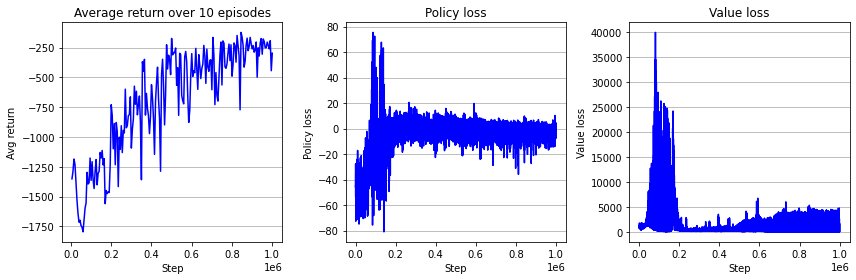

In [9]:
logger = pd.DataFrame(logger)
logger.columns = ['step', 'key', 'value']

fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(1, 3, 1)
key = 'Avg return'
ax.plot(logger.loc[logger['key'] == key, 'step'], logger.loc[logger['key'] == key, 'value'], 'b-')
ax.grid(axis='y')
ax.set_title("Average return over 10 episodes")
ax.set_xlabel("Step")
ax.set_ylabel("Avg return")

ax = fig.add_subplot(1, 3, 2)
key = 'policy_loss'
ax.plot(logger.loc[logger['key'] == key, 'step'], logger.loc[logger['key'] == key, 'value'], 'b-')
ax.grid(axis='y')
ax.set_title("Policy loss")
ax.set_xlabel("Step")
ax.set_ylabel("Policy loss")

ax = fig.add_subplot(1, 3, 3)
key = 'value_loss'
ax.plot(logger.loc[logger['key'] == key, 'step'], logger.loc[logger['key'] == key, 'value'], 'b-')
ax.grid(axis='y')
ax.set_title("Value loss")
ax.set_xlabel("Step")
ax.set_ylabel("Value loss")

fig.tight_layout()
plt.show()

<br>

이것으로 $n$-step return을 사용하는 actor-critic 구현을 마치도록 하겠다. 다음 주제로는 모든 $n$-step return을 가중평균하여 사용하는 Generalized Advantage Estimation (GAE)에 대해서 알아볼 것이다.

<br>

```{raw} html
<script
   type="text/javascript"
   src="https://utteranc.es/client.js"
   async="async"
   repo="HiddenBeginner/Deep-Reinforcement-Learnings"
   issue-term="pathname"
   theme="github-light"
   label="💬 comment"
   crossorigin="anonymous"
/>
```